# Xarxa neuronal

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform as sp_rand
from scipy.stats import randint
from time import time
from sklearn import preprocessing

import math
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


## Consum setmanal total multivariate one-step

In [2]:
daily=pd.read_csv('C:/Users/Laura/Desktop/Smart meters London/workspace R/Dades netes/Final/daily_agr_mitjanaLlarPerDia_tot.csv')
daily.head(5)

,date,apparentTemperatureMax,apparentTemperatureMin,sunsetTimeHour,weekday,season,cloudCover,humidity,visibility,month,dewPoint,pressure,energy_sum
0,2014-02-08,5.67,2.19,17,6,winter,0.47,0.77,11.20,2,3.99,979.25,11.569300
1,2013-12-24,11.93,2.68,15,2,winter,0.40,0.81,10.86,12,5.42,979.52,11.981672
2,2012-11-01,11.46,0.85,16,4,autumn,0.44,0.85,12.54,11,5.06,979.63,10.781689
3,2014-02-05,5.86,1.03,16,3,winter,0.73,0.77,10.91,2,4.06,982.20,11.415105
4,2012-04-17,10.01,2.76,19,2,spring,0.60,0.87,11.86,4,5.74,982.22,10.617443


In [3]:
#Ens quedem amb date i energy_sum, ordenem valors per data i resetejem index
daily_dia=daily[['date','energy_sum','apparentTemperatureMax','apparentTemperatureMin']].sort_values(by=['date']).reset_index()
daily_dia=daily_dia[['date','energy_sum','apparentTemperatureMax','apparentTemperatureMin']]
daily_dia.head(20)


,date,energy_sum,apparentTemperatureMax,apparentTemperatureMin
0,2011-11-23,6.952692,10.36,2.18
1,2011-11-24,8.536480,12.93,7.01
2,2011-11-25,9.499781,13.03,4.84
3,2011-11-26,10.267707,12.96,4.69
4,2011-11-27,10.850805,13.54,2.94
5,2011-11-28,9.103382,12.58,1.31
6,2011-11-29,9.274873,13.47,3.39
7,2011-11-30,8.813513,11.87,3.34
8,2011-12-01,9.227707,12.15,5.29
9,2011-12-02,10.145910,5.33,0.46


In [4]:
#Passem data a datetime
daily_dia["date"] = pd.to_datetime(daily["date"], format='%Y-%m-%d')

In [5]:
import datetime
daily_dia['week']=0
daily_dia['year']=0
for i in range(len(daily_dia)):
    
    daily_dia['week'][i]= daily_dia['date'][i].strftime('%W')
    daily_dia['year'][i]= daily_dia['date'][i].strftime('%Y')
daily_dia

c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,date,energy_sum,apparentTemperatureMax,apparentTemperatureMin,week,year
0,2014-02-08,6.952692,10.36,2.18,5,2014
1,2013-12-24,8.536480,12.93,7.01,51,2013
2,2012-11-01,9.499781,13.03,4.84,44,2012
3,2014-02-05,10.267707,12.96,4.69,5,2014
4,2012-04-17,10.850805,13.54,2.94,16,2012
5,2012-04-18,9.103382,12.58,1.31,16,2012
6,2013-12-25,9.274873,13.47,3.39,51,2013
7,2014-02-09,8.813513,11.87,3.34,5,2014
8,2014-01-28,9.227707,12.15,5.29,4,2014
9,2012-12-14,10.145910,5.33,0.46,50,2012


In [9]:
daily_week= daily_dia.groupby(by=['year','week']).sum()

In [10]:
daily_week

energy_sum  apparentTemperatureMax  apparentTemperatureMin
year week                                                            
2011 47     51.114714                   70.67                   41.73
     48     65.571115                  111.13                   63.16
     49     63.016513                  117.25                   57.62
     50     82.034950                   68.42                   26.70
     51     75.672988                   77.77                   23.58
     52     59.108348                   78.15                   42.57
2012 0      10.675958                    7.28                    4.53
     1      69.481120                  104.06                   53.30
     2      81.510830                   65.40                   14.72
     3      69.813180                   97.48                   41.30
     4      70.707853                   84.95                   38.71
     5      76.962281                   61.81                   24.32
     6      75.172341                   66.99                   15.38
     7      69.506432                  109.90                   56.36
     8      73.889743                   90.33                   35.41
     9      69.289775                   88.84                   34.64
     10     73.896709                   95.91                   38.71
     11     74.495490                   81.83                   28.21
     12     93.630022                   53.57                    5.47
     13     67.918920                  112.48                   57.91
     14     77.113029                   77.07                   23.69
     15     71.793072                  106.22                   51.59
     16     80.333027                   65.84                    8.96
     17     77.781531                   69.61                   28.21
     18     71.854679                   90.02                   55.94
     19     65.779445                  104.08                   55.79
     20     67.507820                  101.91                   51.37
     21     63.278685                  123.67                   69.41
     22     71.630877                   65.12                   25.98
     23     81.842540                   70.05                   17.85
...               ...                     ...                     ...
2013 32     65.696722                  121.75                   66.28
     33     71.339482                   93.73                   40.54
     34     65.437931                  104.52                   61.85
     35     69.160818                  102.64                   53.02
     36     65.619442                  121.08                   55.72
     37     69.474258                  112.72                   65.23
     38     72.644275                   79.24                   48.42
     39     61.162204                  138.10                   73.43
     40     61.307206                  118.27                   68.44
     41     68.287755                  105.45                   48.73
     42     86.817619                   38.43                   -4.35
     43     74.077658                  108.12                   46.54
     44     78.895956                   73.66                   27.47
     45     71.739465                   88.71                   38.36
     46     72.005948                   88.04                   40.53
     47     80.713782                   61.95                   22.52
     48     76.877442                   68.29                   14.59
     49     69.451989                  110.00                   50.26
     50     70.245566                  108.00                   63.73
     51     82.914623                   50.61                   11.13
     52     18.612574                   29.51                   10.63
2014 0      62.324195                   60.50                   33.09
     1      75.867974                   85.48                   26.51
     2      90.607556                   49.60                   -3.94
     3      71.472853

In [11]:
#Passem de mitjana per llar de consum diari a mitjana per llar de consum setmanal

daily_week['apparentTemperatureMax']=daily_week['apparentTemperatureMax']/7
daily_week['apparentTemperatureMin']=daily_week['apparentTemperatureMin']/7
daily_week

energy_sum  apparentTemperatureMax  apparentTemperatureMin
year week                                                            
2011 47     51.114714               10.095714                5.961429
     48     65.571115               15.875714                9.022857
     49     63.016513               16.750000                8.231429
     50     82.034950                9.774286                3.814286
     51     75.672988               11.110000                3.368571
     52     59.108348               11.164286                6.081429
2012 0      10.675958                1.040000                0.647143
     1      69.481120               14.865714                7.614286
     2      81.510830                9.342857                2.102857
     3      69.813180               13.925714                5.900000
     4      70.707853               12.135714                5.530000
     5      76.962281                8.830000                3.474286
     6      75.172341                9.570000                2.197143
     7      69.506432               15.700000                8.051429
     8      73.889743               12.904286                5.058571
     9      69.289775               12.691429                4.948571
     10     73.896709               13.701429                5.530000
     11     74.495490               11.690000                4.030000
     12     93.630022                7.652857                0.781429
     13     67.918920               16.068571                8.272857
     14     77.113029               11.010000                3.384286
     15     71.793072               15.174286                7.370000
     16     80.333027                9.405714                1.280000
     17     77.781531                9.944286                4.030000
     18     71.854679               12.860000                7.991429
     19     65.779445               14.868571                7.970000
     20     67.507820               14.558571                7.338571
     21     63.278685               17.667143                9.915714
     22     71.630877                9.302857                3.711429
     23     81.842540               10.007143                2.550000
...               ...                     ...                     ...
2013 32     65.696722               17.392857                9.468571
     33     71.339482               13.390000                5.791429
     34     65.437931               14.931429                8.835714
     35     69.160818               14.662857                7.574286
     36     65.619442               17.297143                7.960000
     37     69.474258               16.102857                9.318571
     38     72.644275               11.320000                6.917143
     39     61.162204               19.728571               10.490000
     40     61.307206               16.895714                9.777143
     41     68.287755               15.064286                6.961429
     42     86.817619                5.490000               -0.621429
     43     74.077658               15.445714                6.648571
     44     78.895956               10.522857                3.924286
     45     71.739465               12.672857                5.480000
     46     72.005948               12.577143                5.790000
     47     80.713782                8.850000                3.217143
     48     76.877442                9.755714                2.084286
     49     69.451989               15.714286                7.180000
     50     70.245566               15.428571                9.104286
     51     82.914623                7.230000                1.590000
     52     18.612574                4.215714                1.518571
2014 0      62.324195                8.642857                4.727143
     1      75.867974               12.211429                3.787143
     2      90.607556                7.085714               -0.562857
     3      71.472853

In [12]:
daily_week=daily_week.reset_index()
daily_week

,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin
0,2011,47,51.114714,10.095714,5.961429
1,2011,48,65.571115,15.875714,9.022857
2,2011,49,63.016513,16.750000,8.231429
3,2011,50,82.034950,9.774286,3.814286
4,2011,51,75.672988,11.110000,3.368571
5,2011,52,59.108348,11.164286,6.081429
6,2012,0,10.675958,1.040000,0.647143
7,2012,1,69.481120,14.865714,7.614286
8,2012,2,81.510830,9.342857,2.102857
9,2012,3,69.813180,13.925714,5.900000


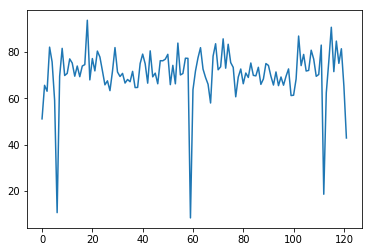

In [13]:
plt.plot(daily_week.energy_sum)

In [14]:
#Comprovem quines son les setmanes 0
(daily_week[daily_week.week==0])

,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin
6,2012,0,10.675958,1.040000,0.647143
60,2013,0,63.657653,7.481429,2.308571
113,2014,0,62.324195,8.642857,4.727143


In [15]:
(daily_week[daily_week.week==52])

,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin
5,2011,52,59.108348,11.164286,6.081429
58,2012,52,77.198766,10.284286,3.937143
112,2013,52,18.612574,4.215714,1.518571


In [16]:
(daily_week[daily_week.week==53])

,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin
59,2012,53,8.405077,2.504286,1.634286


In [17]:
#Sumem les setmanes 52 i la 0 seguent ja que son la mateixa però de diferents anys 

n1_52=daily_week.energy_sum[(daily_week.year==2011) & (daily_week.week==52)]
n1_0= daily_week.energy_sum[(daily_week.year==2012) & (daily_week.week==0)]
nombre1= n1_52.item() + n1_0.item()

n2_52=daily_week.energy_sum[(daily_week.year==2012) & (daily_week.week==53)] 
n2_0=daily_week.energy_sum[(daily_week.year==2013) & (daily_week.week==0)]

nombre2=n2_52.item() + n2_0.item()

n3_52=daily_week.energy_sum[(daily_week.year==2013) & (daily_week.week==52)] 
n3_0=daily_week.energy_sum[(daily_week.year==2014) & (daily_week.week==0)]
nombre3=n3_52.item() + n3_0.item()

daily_week.energy_sum[(daily_week.year==2011) & (daily_week.week==52)]=nombre1

daily_week.energy_sum[(daily_week.year==2013) & (daily_week.week==0)]=nombre2
daily_week.energy_sum[(daily_week.year==2014) & (daily_week.week==0)]=nombre3


daily_week




c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin
0,2011,47,51.114714,10.095714,5.961429
1,2011,48,65.571115,15.875714,9.022857
2,2011,49,63.016513,16.750000,8.231429
3,2011,50,82.034950,9.774286,3.814286
4,2011,51,75.672988,11.110000,3.368571
5,2011,52,69.784306,11.164286,6.081429
6,2012,0,10.675958,1.040000,0.647143
7,2012,1,69.481120,14.865714,7.614286
8,2012,2,81.510830,9.342857,2.102857
9,2012,3,69.813180,13.925714,5.900000


In [18]:
#Les eliminem (setmana 0 del 2012, setmana 53 del 2012  i setmana 52 del 2013)
daily_week=daily_week.drop([6,59,112])
daily_week

,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin
0,2011,47,51.114714,10.095714,5.961429
1,2011,48,65.571115,15.875714,9.022857
2,2011,49,63.016513,16.750000,8.231429
3,2011,50,82.034950,9.774286,3.814286
4,2011,51,75.672988,11.110000,3.368571
5,2011,52,69.784306,11.164286,6.081429
7,2012,1,69.481120,14.865714,7.614286
8,2012,2,81.510830,9.342857,2.102857
9,2012,3,69.813180,13.925714,5.900000
10,2012,4,70.707853,12.135714,5.530000


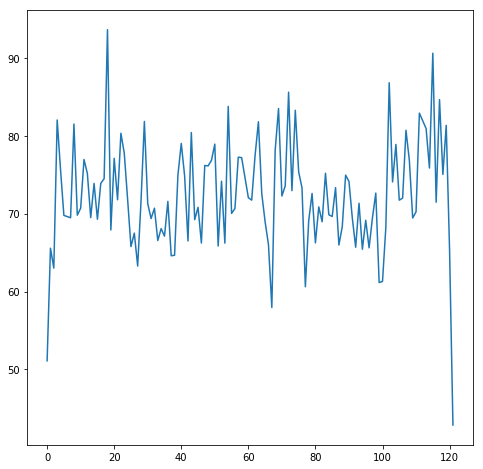

In [19]:
plt.figure(figsize=(8,8))

plt.plot(daily_week.energy_sum )

Ja tenim el fitxer preparat.

In [20]:
daily_week['t-1']=daily_week['energy_sum'].shift(1)
daily_week['t-2']=daily_week['energy_sum'].shift(2)
daily_week['t-3']=daily_week['energy_sum'].shift(3)
daily_week['t-4']=daily_week['energy_sum'].shift(4)
daily_week['t-5']=daily_week['energy_sum'].shift(5)
daily_week['t-6']=daily_week['energy_sum'].shift(6)
daily_week['t-7']=daily_week['energy_sum'].shift(7)

daily_week['temp(t-1)']=daily_week['apparentTemperatureMax'].shift(1)
daily_week['temp(t-2)']=daily_week['apparentTemperatureMax'].shift(2)
daily_week['temp(t-3)']=daily_week['apparentTemperatureMax'].shift(3)
daily_week['temp(t-4)']=daily_week['apparentTemperatureMax'].shift(4)
daily_week['temp(t-5)']=daily_week['apparentTemperatureMax'].shift(5)
daily_week['temp(t-6)']=daily_week['apparentTemperatureMax'].shift(6)
daily_week['temp(t-7)']=daily_week['apparentTemperatureMax'].shift(7)
daily_week['temp(t-8)']=daily_week['apparentTemperatureMax'].shift(8)

daily_week['tempmin(t-1)']=daily_week['apparentTemperatureMin'].shift(1)
daily_week['tempmin(t-2)']=daily_week['apparentTemperatureMin'].shift(2)
daily_week['tempmin(t-3)']=daily_week['apparentTemperatureMin'].shift(3)
daily_week['tempmin(t-4)']=daily_week['apparentTemperatureMin'].shift(4)
daily_week['tempmin(t-5)']=daily_week['apparentTemperatureMin'].shift(5)
daily_week['tempmin(t-6)']=daily_week['apparentTemperatureMin'].shift(6)
daily_week['tempmin(t-7)']=daily_week['apparentTemperatureMin'].shift(7)
daily_week['tempmin(t-8)']=daily_week['apparentTemperatureMin'].shift(8)


daily_week

,year,week,energy_sum,apparentTemperatureMax,apparentTemperatureMin,t-1,t-2,t-3,t-4,t-5,...,temp(t-7),temp(t-8),tempmin(t-1),tempmin(t-2),tempmin(t-3),tempmin(t-4),tempmin(t-5),tempmin(t-6),tempmin(t-7),tempmin(t-8)
0,2011,47,51.114714,10.095714,5.961429,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,48,65.571115,15.875714,9.022857,51.114714,NaN,NaN,NaN,NaN,...,NaN,NaN,5.961429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,49,63.016513,16.750000,8.231429,65.571115,51.114714,NaN,NaN,NaN,...,NaN,NaN,9.022857,5.961429,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,50,82.034950,9.774286,3.814286,63.016513,65.571115,51.114714,NaN,NaN,...,NaN,NaN,8.231429,9.022857,5.961429,NaN,NaN,NaN,NaN,NaN
4,2011,51,75.672988,11.110000,3.368571,82.034950,63.016513,65.571115,51.114714,NaN,...,NaN,NaN,3.814286,8.231429,9.022857,5.961429,NaN,NaN,NaN,NaN
5,2011,52,69.784306,11.164286,6.081429,75.672988,82.034950,63.016513,65.571115,51.114714,...,NaN,NaN,3.368571,3.814286,8.231429,9.022857,5.961429,NaN,NaN,NaN
7,2012,1,69.481120,14.865714,7.614286,69.784306,75.672988,82.034950,63.016513,65.571115,...,NaN,NaN,6.081429,3.368571,3.814286,8.231429,9.022857,5.961429,NaN,NaN
8,2012,2,81.510830,9.342857,2.102857,69.481120,69.784306,75.672988,82.034950,63.016513,...,10.095714,NaN,7.614286,6.081429,3.368571,3.814286,8.231429,9.022857,5.961429,NaN
9,2012,3,69.813180,13.925714,5.900000,81.510830,69.481120,69.784306,75.672988,82.034950,...,15.875714,10.095714,2.102857,7.614286,6.081429,3.368571,3.814286,8.231429,9.022857,5.961429
10,2012,4,70.707853,12.135714,5.530000,69.813180,81.510830,69.481120,69.784306,75.672988,...,16.750000,15.875714,5.900000,2.102857,7.614286,6.081429,3.368571,3.814286,8.231429,9.022857


In [21]:
#Ens quedem amb energies i temperatures passades
daily_week=daily_week[['energy_sum','t-1','t-2','t-3','t-4','t-5','t-6','t-7','temp(t-1)','temp(t-2)','temp(t-3)','temp(t-4)','temp(t-5)','temp(t-6)','temp(t-7)','tempmin(t-1)','tempmin(t-2)','tempmin(t-3)','tempmin(t-4)','tempmin(t-5)','tempmin(t-6)','tempmin(t-7)']]
daily_week.head(5)


,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7,temp(t-1),temp(t-2),...,temp(t-5),temp(t-6),temp(t-7),tempmin(t-1),tempmin(t-2),tempmin(t-3),tempmin(t-4),tempmin(t-5),tempmin(t-6),tempmin(t-7)
0,51.114714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65.571115,51.114714,NaN,NaN,NaN,NaN,NaN,NaN,10.095714,NaN,...,NaN,NaN,NaN,5.961429,NaN,NaN,NaN,NaN,NaN,NaN
2,63.016513,65.571115,51.114714,NaN,NaN,NaN,NaN,NaN,15.875714,10.095714,...,NaN,NaN,NaN,9.022857,5.961429,NaN,NaN,NaN,NaN,NaN
3,82.034950,63.016513,65.571115,51.114714,NaN,NaN,NaN,NaN,16.750000,15.875714,...,NaN,NaN,NaN,8.231429,9.022857,5.961429,NaN,NaN,NaN,NaN
4,75.672988,82.034950,63.016513,65.571115,51.114714,NaN,NaN,NaN,9.774286,16.750000,...,NaN,NaN,NaN,3.814286,8.231429,9.022857,5.961429,NaN,NaN,NaN


In [22]:
daily_week=daily_week.reset_index()
daily_week=daily_week[['energy_sum','t-1','t-2','t-3','t-4','t-5','t-6','t-7','temp(t-1)','temp(t-2)','temp(t-3)','temp(t-4)','temp(t-5)','temp(t-6)','temp(t-7)','tempmin(t-1)','tempmin(t-2)','tempmin(t-3)','tempmin(t-4)','tempmin(t-5)','tempmin(t-6)','tempmin(t-7)']]
daily_week.head(5)


,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7,temp(t-1),temp(t-2),...,temp(t-5),temp(t-6),temp(t-7),tempmin(t-1),tempmin(t-2),tempmin(t-3),tempmin(t-4),tempmin(t-5),tempmin(t-6),tempmin(t-7)
0,51.114714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65.571115,51.114714,NaN,NaN,NaN,NaN,NaN,NaN,10.095714,NaN,...,NaN,NaN,NaN,5.961429,NaN,NaN,NaN,NaN,NaN,NaN
2,63.016513,65.571115,51.114714,NaN,NaN,NaN,NaN,NaN,15.875714,10.095714,...,NaN,NaN,NaN,9.022857,5.961429,NaN,NaN,NaN,NaN,NaN
3,82.034950,63.016513,65.571115,51.114714,NaN,NaN,NaN,NaN,16.750000,15.875714,...,NaN,NaN,NaN,8.231429,9.022857,5.961429,NaN,NaN,NaN,NaN
4,75.672988,82.034950,63.016513,65.571115,51.114714,NaN,NaN,NaN,9.774286,16.750000,...,NaN,NaN,NaN,3.814286,8.231429,9.022857,5.961429,NaN,NaN,NaN


In [23]:
#Eliminem les 7 primeres files ja que contenen NaN (valors buits)
daily_week=daily_week.drop([0,1,2,3,4,5,6])
daily_week.head(5)

,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7,temp(t-1),temp(t-2),...,temp(t-5),temp(t-6),temp(t-7),tempmin(t-1),tempmin(t-2),tempmin(t-3),tempmin(t-4),tempmin(t-5),tempmin(t-6),tempmin(t-7)
7,81.510830,69.481120,69.784306,75.672988,82.034950,63.016513,65.571115,51.114714,14.865714,11.164286,...,16.750000,15.875714,10.095714,7.614286,6.081429,3.368571,3.814286,8.231429,9.022857,5.961429
8,69.813180,81.510830,69.481120,69.784306,75.672988,82.034950,63.016513,65.571115,9.342857,14.865714,...,9.774286,16.750000,15.875714,2.102857,7.614286,6.081429,3.368571,3.814286,8.231429,9.022857
9,70.707853,69.813180,81.510830,69.481120,69.784306,75.672988,82.034950,63.016513,13.925714,9.342857,...,11.110000,9.774286,16.750000,5.900000,2.102857,7.614286,6.081429,3.368571,3.814286,8.231429
10,76.962281,70.707853,69.813180,81.510830,69.481120,69.784306,75.672988,82.034950,12.135714,13.925714,...,11.164286,11.110000,9.774286,5.530000,5.900000,2.102857,7.614286,6.081429,3.368571,3.814286
11,75.172341,76.962281,70.707853,69.813180,81.510830,69.481120,69.784306,75.672988,8.830000,12.135714,...,14.865714,11.164286,11.110000,3.474286,5.530000,5.900000,2.102857,7.614286,6.081429,3.368571


In [124]:
len(daily_week)


112

Instructions for updating:
Colocations handled automatically by placer.


In [24]:

#normalitzem
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
daily_week_norm=scaler.fit_transform(daily_week)


In [25]:
#Partim en X i y(valor a predir)

#Seleccionem dades per y i X
y_week=daily_week_norm[:,0]
X_week=daily_week_norm[:,1:29]

#Reshape de [samples,timesteps] a [samples,timesteps,features]
#X_daily_list=X_daily.values#.tolist()
X_week=np.reshape(X_week, (X_week.shape[0],7,3))


In [18]:
len(X_week)

112

In [27]:

# definim model
import tensorflow as tf
model =Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


#Walk forward per test i train
minim=2
n_train=55
lenght=len(daily_week)-1

llista_evaluate=list()
llista_prediccions=list()
llista_preditrain=list()
llista_scores=list()
llista_scoretrain=list()
sumScores=0

for i in range(n_train,lenght):
    minim=minim+1
    X_train,X_test= X_week[minim:i],X_week[i:i+1]
    y_train,y_test= y_week[minim:i],y_week[i:i+1]

    #fem fit al model
    model.fit(X_train, y_train, epochs=50, verbose=0)
    
    #mostrem score per cada model
    score=model.evaluate(X_test,y_test,verbose=0)
    llista_evaluate.append(score)
    
    #Predim per cadascun
    preditest=model.predict(X_test)
    llista_prediccions.append(preditest)
    
    preditrain=model.predict(X_train)
    llista_preditrain.append(preditrain)
    
    trainScore = math.sqrt(mean_squared_error(y_train, preditrain))
    llista_scoretrain.append(trainScore )
    

    testScore = math.sqrt(mean_squared_error(y_test, preditest))
    llista_scores.append(testScore)
   
    sumScores=sumScores+testScore
    


Instructions for updating:
Use tf.cast instead.


In [28]:
#Dividim la suma de scores de test entre el nombre de prediccions per obtenir la mitjana
sumScores/(lenght-n_train)



0.18526804429420407

In [29]:
predis=list()

for i in range(len(llista_prediccions)):
    predi=llista_prediccions[i].tolist()
    predis.append(predi)

predis=np.reshape(predis, (56))

predis

array([0.54526418, 0.52887022, 0.53626031, 0.56864125, 0.58610916,
       0.6268611 , 0.68082237, 0.61409605, 0.80668217, 0.51266319,
       0.53236502, 0.7358551 , 1.12101007, 0.69285834, 0.69615304,
       0.68232453, 0.77212977, 0.80255598, 0.56524223, 0.63820714,
       0.4962166 , 0.4652991 , 0.46541533, 0.56714219, 0.4897694 ,
       0.46476638, 0.6424107 , 0.56692916, 0.45989737, 0.51178348,
       0.66953462, 0.49274987, 0.47173658, 0.56253278, 0.53315634,
       0.57204646, 0.61961538, 0.67534482, 0.94406712, 0.44516098,
       0.29154176, 0.94113815, 0.67404467, 0.32466027, 0.79000705,
       0.6981163 , 0.46185476, 0.38694209, 0.47651404, 0.31708619,
       0.40995732, 0.77893984, 0.13033997, 1.04714549, 0.41361097,
       0.99083596])

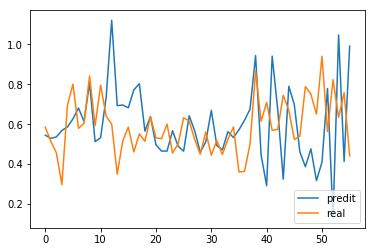

In [30]:
##Mostrem
plt.plot(predis, label="predit")
plt.plot(y_week[n_train:lenght], label="real")
plt.legend(loc="lower right")
plt.show()

In [32]:

prova=daily_week.iloc[n_train:lenght]
prova
#len(predis)
#lenght-n_train
prova['predi']=predis
prova['y']=y_week[n_train:lenght]
prova=prova.drop(['energy_sum','t-1'], axis=1)
prova

prova=prova[['predi','y','t-2','t-3','t-4','t-5','t-6','t-7','temp(t-1)','temp(t-2)','temp(t-3)','temp(t-4)','temp(t-5)','temp(t-6)','temp(t-7)','tempmin(t-1)','tempmin(t-2)','tempmin(t-3)','tempmin(t-4)','tempmin(t-5)','tempmin(t-6)','tempmin(t-7)']]
prova

c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,predi,y,t-2,t-3,t-4,t-5,t-6,t-7,temp(t-1),temp(t-2),...,temp(t-5),temp(t-6),temp(t-7),tempmin(t-1),tempmin(t-2),tempmin(t-3),tempmin(t-4),tempmin(t-5),tempmin(t-6),tempmin(t-7)
62,0.545264,0.585234,77.437620,71.744692,72.062731,77.198766,77.260768,70.664219,10.950000,12.012857,...,10.284286,11.920000,14.197143,4.078571,4.364286,5.054286,2.308571,3.937143,4.064286,6.544286
63,0.528870,0.513990,81.810558,77.437620,71.744692,72.062731,77.198766,77.260768,10.742857,10.950000,...,7.481429,10.284286,11.920000,3.617143,4.078571,4.364286,5.054286,2.308571,3.937143,4.064286
64,0.536260,0.456374,72.574976,81.810558,77.437620,71.744692,72.062731,77.198766,15.165714,10.742857,...,11.415714,7.481429,10.284286,6.892857,3.617143,4.078571,4.364286,5.054286,2.308571,3.937143
65,0.568641,0.297209,68.958373,72.574976,81.810558,77.437620,71.744692,72.062731,16.284286,15.165714,...,12.012857,11.415714,7.481429,8.255714,6.892857,3.617143,4.078571,4.364286,5.054286,2.308571
66,0.586109,0.695217,66.033571,68.958373,72.574976,81.810558,77.437620,71.744692,23.265714,16.284286,...,10.950000,12.012857,11.415714,13.784286,8.255714,6.892857,3.617143,4.078571,4.364286,5.054286
67,0.626861,0.800479,57.953783,66.033571,68.958373,72.574976,81.810558,77.437620,10.168571,23.265714,...,10.742857,10.950000,12.012857,2.300000,13.784286,8.255714,6.892857,3.617143,4.078571,4.364286
68,0.680822,0.579275,78.158107,57.953783,66.033571,68.958373,72.574976,81.810558,8.278571,10.168571,...,15.165714,10.742857,10.950000,0.571429,2.300000,13.784286,8.255714,6.892857,3.617143,4.078571
69,0.614096,0.604790,83.501617,78.158107,57.953783,66.033571,68.958373,72.574976,12.042857,8.278571,...,16.284286,15.165714,10.742857,5.510000,0.571429,2.300000,13.784286,8.255714,6.892857,3.617143
70,0.806682,0.841917,72.272519,83.501617,78.158107,57.953783,66.033571,68.958373,14.291429,12.042857,...,23.265714,16.284286,15.165714,8.212857,5.510000,0.571429,2.300000,13.784286,8.255714,6.892857
71,0.512663,0.592762,73.567716,72.272519,83.501617,78.158107,57.953783,66.033571,12.585714,14.291429,...,10.168571,23.265714,16.284286,3.828571,8.212857,5.510000,0.571429,2.300000,13.784286,8.255714


In [33]:
predi = scaler.inverse_transform(prova)

In [34]:
#Fem una llista amb les prediccions i una llista amb y(valor real)

listpredi=list()
for i in range(len(predi)):
    listpredi.append(predi[i][0])


listy=list()
for i in range(len(predi)):
    listy.append(predi[i][1])


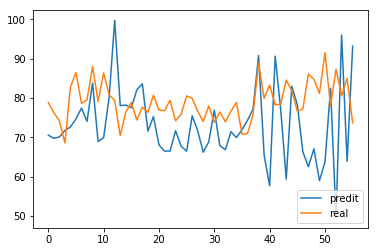

In [35]:
##Mostrem
plt.plot(listpredi, label="predit")
plt.plot(listy, label="real")
plt.legend(loc="lower right")
plt.show()

In [36]:
llista_errors=list()
llista_errorsabs=list()
llista_errorsres=list()

    
for i in range(len(listpredi)):
    valor=listy[i]-listpredi[i]
    valorabs=math.fabs(valor)
    valorrespecte=valorabs/listy[i]
    llista_errors.append(valor)
    llista_errorsabs.append(valorabs)
    llista_errorsres.append(valorrespecte)


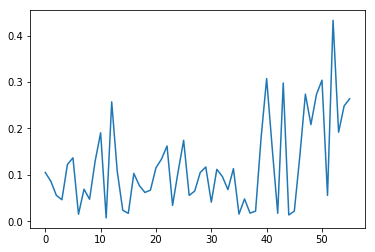

In [37]:
plt.plot(llista_errorsres)

In [38]:
sum(llista_errorsres)/(len(llista_errorsres))

0.12004697727169544